In [1]:
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium import webdriver
import pandas as pd
import time
import os
import pickle

# Créer le dossier data s'il n'existe pas
os.makedirs('data', exist_ok=True)

## Scrape Historical Data (1972-2023)

In [ ]:
def get_data_for_year(driver, year):
    url = f"https://fr.wikipedia.org/wiki/Coupe_d%27Afrique_des_nations_de_football_{year}"
    year_matches = []

    try:
        driver.get(url)
        print(f"Scraping CAN {year}...")
    except:
        print(f"ERREUR: Impossible de charger la page pour l'annee {year}")
        return []

    tables = driver.find_elements(By.TAG_NAME, "table")

    for table in tables:
        try:
            rows = table.find_elements(By.TAG_NAME, "tr")
            if not rows:
                print(f"Table ignoree ({year}): Aucune ligne trouvee")
                continue

            cells = rows[0].find_elements(By.TAG_NAME, "td")
            if len(cells) < 5:
                print(f"Table ignoree ({year}): Structure invalide ({len(cells)} colonnes au lieu de 5)")
                continue
                

            score_text = cells[2].text
            #score_text = score_text.replace("–", "-")
            if "-" not in score_text:
                print(f"Table ignoree ({year}): Format de score invalide '{score_text}'")
                continue
                

            date = cells[0].text.strip()
            team_A = cells[1].text.strip()
            team_B = cells[3].text.strip()
            stadium = cells[4].text.strip()

            goals_A, goals_B = score_text.split("-")

            year_matches.append([
                year,
                date,
                team_A,
                team_B,
                goals_A.strip(),
                goals_B.strip(),
                stadium
            ])

        except Exception as e:
            print(f"ERREUR lors du traitement d'une table ({year}): {str(e)[:50]}")
            continue

    print(f"   -> {len(year_matches)} matchs extraits pour {year}")
    return year_matches

In [4]:
service = Service("chromedriver.exe")
driver = webdriver.Chrome(service=service)

matches = []
years = [
    1972, 1974, 1976,
    1978, 1980, 1982, 1984, 1986,
    1988, 1990, 1992, 1994, 1996,
    1998, 2000, 2002, 2004, 2006,
    2008, 2010, 2012, 2013, 2015,
    2017, 2019, 2021, 2023
]

print("="*50)
print("SCRAPING DES DONNEES HISTORIQUES CAN (1972-2023)")
print("="*50)

for year in years:
    year_data = get_data_for_year(driver, year)
    matches.extend(year_data)
    time.sleep(1)  

driver.quit()

print("="*50)
print(f"TERMINE: {len(matches)} matchs extraits au total")
print("="*50)

SCRAPING DES DONNEES HISTORIQUES CAN (1972-2023)
Scraping CAN 1972...
Table ignoree (1972): Structure invalide (1 colonnes au lieu de 5)
Table ignoree (1972): Structure invalide (1 colonnes au lieu de 5)
Table ignoree (1972): Structure invalide (1 colonnes au lieu de 5)
Table ignoree (1972): Structure invalide (0 colonnes au lieu de 5)
Table ignoree (1972): Structure invalide (0 colonnes au lieu de 5)
Table ignoree (1972): Structure invalide (0 colonnes au lieu de 5)
Table ignoree (1972): Format de score invalide 'Peter Schnittger'
Table ignoree (1972): Structure invalide (1 colonnes au lieu de 5)
Table ignoree (1972): Structure invalide (1 colonnes au lieu de 5)
Table ignoree (1972): Format de score invalide 'Adolphe Bibanzoulou'
Table ignoree (1972): Structure invalide (1 colonnes au lieu de 5)
Table ignoree (1972): Structure invalide (1 colonnes au lieu de 5)
Table ignoree (1972): Structure invalide (0 colonnes au lieu de 5)
Table ignoree (1972): Structure invalide (0 colonnes au li

In [5]:
df = pd.DataFrame(matches, columns=["year","date", "team_A", "team_B", "goals_A", "goals_B", "stadium"])
print(f"Shape: {df.shape}")
df.head()

Shape: (366, 7)


,year,date,team_A,team_B,goals_A,goals_B,stadium
0,1972,23 février 1972,Cameroun,Kenya,2,1,"Stade omnisports, Yaoundé"
1,1972,24 février 1972,Mali,Togo,3,3,"Stade omnisports, Yaoundé"
2,1972,26 février 1972,Mali,Kenya,1,1,"Stade omnisports, Yaoundé"
3,1972,26 février 1972,Cameroun,Togo,2,0,"Stade omnisports, Yaoundé"
4,1972,28 février 1972,Togo,Kenya,1,1,"Stade omnisports, Yaoundé"


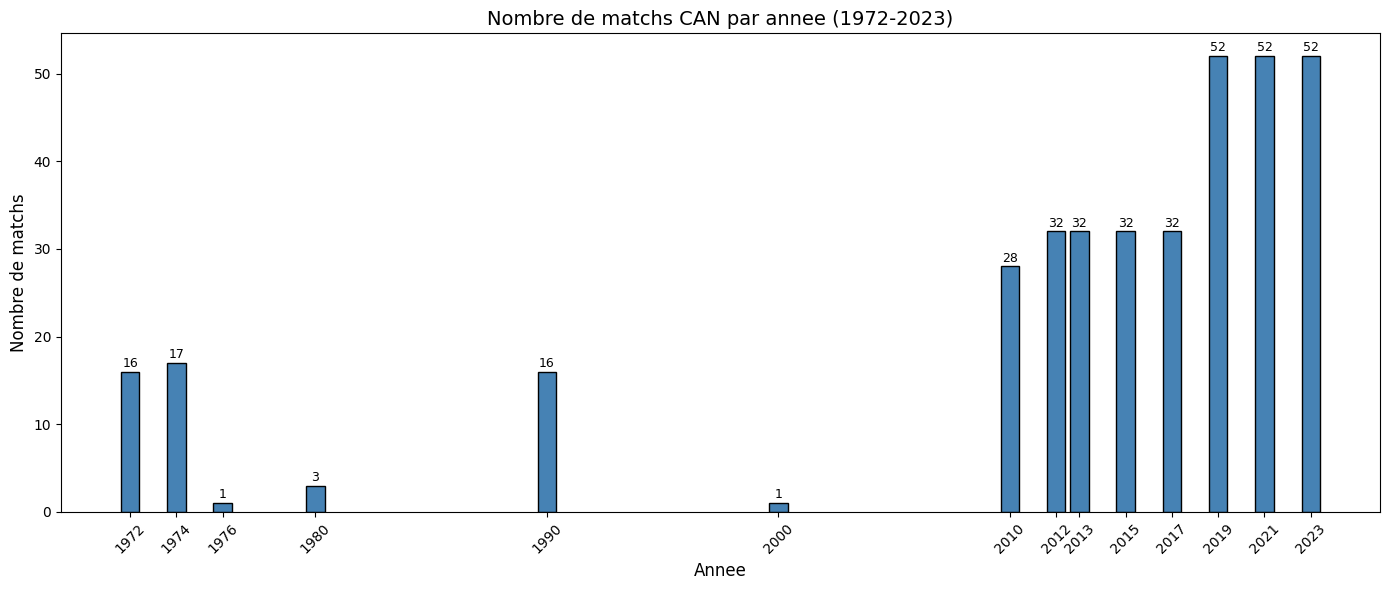

Graphique sauvegarde dans: images/matches_per_year.png
Total: 366 matchs sur 14 editions


In [6]:
import matplotlib.pyplot as plt

# Creer le dossier images s'il n'existe pas
os.makedirs('images', exist_ok=True)

# Calculer le nombre de matchs par annee
matches_per_year = df.groupby('year').size()

# Creer le graphique
plt.figure(figsize=(14, 6))
plt.bar(matches_per_year.index, matches_per_year.values, color='steelblue', edgecolor='black')
plt.xlabel('Annee', fontsize=12)
plt.ylabel('Nombre de matchs', fontsize=12)
plt.title('Nombre de matchs CAN par annee (1972-2023)', fontsize=14)
plt.xticks(matches_per_year.index, rotation=45)

# Ajouter les valeurs sur chaque barre
for year, count in zip(matches_per_year.index, matches_per_year.values):
    plt.text(year, count + 0.2, str(count), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('images/matches_per_year.png', dpi=150)
plt.show()

print(f"Graphique sauvegarde dans: images/matches_per_year.png")
print(f"Total: {matches_per_year.sum()} matchs sur {len(matches_per_year)} editions")

### Correction de la fonction de scraping

**Probleme identifie:** Le scraping ne retournait aucun match car la condition `if "-" not in score_text` etait toujours vraie.

**Cause:** Wikipedia utilise le caractere **EN DASH** `–` (U+2013) dans les scores (ex: `2 – 1`), alors que le code cherchait le tiret **ASCII** `-` (U+002D). Ces deux caracteres sont visuellement similaires mais differents : `"–" != "-"`.

**Solution:** Ajouter la ligne `score_text = score_text.replace("–", "-")` pour convertir le EN DASH en tiret ASCII avant de parser le score.

In [8]:
def get_data_for_year(driver, year):
    url = f"https://fr.wikipedia.org/wiki/Coupe_d%27Afrique_des_nations_de_football_{year}"
    year_matches = []

    try:
        driver.get(url)
        print(f"Scraping CAN {year}...")
    except:
        print(f"ERREUR: Impossible de charger la page pour l'annee {year}")
        return []

    tables = driver.find_elements(By.TAG_NAME, "table")

    for table in tables:
        try:
            rows = table.find_elements(By.TAG_NAME, "tr")
            if not rows:
                print(f"Table ignoree ({year}): Aucune ligne trouvee")
                continue

            cells = rows[0].find_elements(By.TAG_NAME, "td")
            if len(cells) < 5:
                print(f"Table ignoree ({year}): Structure invalide ({len(cells)} colonnes au lieu de 5)")
                continue
                

            score_text = cells[2].text
            score_text = score_text.replace("–", "-") #Ajout de ce ligne
            if "-" not in score_text:
                print(f"Table ignoree ({year}): Format de score invalide '{score_text}'")
                continue
                

            date = cells[0].text.strip()
            team_A = cells[1].text.strip()
            team_B = cells[3].text.strip()
            stadium = cells[4].text.strip()

            goals_A, goals_B = score_text.split("-")

            year_matches.append([
                year,
                date,
                team_A,
                team_B,
                goals_A.strip(),
                goals_B.strip(),
                stadium
            ])

        except Exception as e:
            print(f"ERREUR lors du traitement d'une table ({year}): {str(e)[:50]}")
            continue

    print(f"   -> {len(year_matches)} matchs extraits pour {year}")
    return year_matches

In [9]:
service = Service("chromedriver.exe")
driver = webdriver.Chrome(service=service)

matches_2 = []
years = [
    1972, 1974, 1976,
    1978, 1980, 1982, 1984, 1986,
    1988, 1990, 1992, 1994, 1996,
    1998, 2000, 2002, 2004, 2006,
    2008, 2010, 2012, 2013, 2015,
    2017, 2019, 2021, 2023
]

print("="*50)
print("SCRAPING DES DONNEES HISTORIQUES CAN (1972-2023)")
print("="*50)

for year in years:
    year_data = get_data_for_year(driver, year)
    matches_2.extend(year_data)
    time.sleep(1)  

driver.quit()

print("="*50)
print(f"TERMINE: {len(matches_2)} matchs extraits au total")
print("="*50)

SCRAPING DES DONNEES HISTORIQUES CAN (1972-2023)
Scraping CAN 1972...
Table ignoree (1972): Structure invalide (1 colonnes au lieu de 5)
Table ignoree (1972): Structure invalide (1 colonnes au lieu de 5)
Table ignoree (1972): Structure invalide (1 colonnes au lieu de 5)
Table ignoree (1972): Structure invalide (0 colonnes au lieu de 5)
Table ignoree (1972): Structure invalide (0 colonnes au lieu de 5)
Table ignoree (1972): Structure invalide (0 colonnes au lieu de 5)
Table ignoree (1972): Format de score invalide 'Peter Schnittger'
Table ignoree (1972): Structure invalide (1 colonnes au lieu de 5)
Table ignoree (1972): Structure invalide (1 colonnes au lieu de 5)
Table ignoree (1972): Format de score invalide 'Adolphe Bibanzoulou'
Table ignoree (1972): Structure invalide (1 colonnes au lieu de 5)
Table ignoree (1972): Structure invalide (1 colonnes au lieu de 5)
Table ignoree (1972): Structure invalide (0 colonnes au lieu de 5)
Table ignoree (1972): Structure invalide (0 colonnes au li

In [27]:
df = pd.DataFrame(matches_2, columns=["year","date", "team_A", "team_B", "goals_A", "goals_B", "stadium"])
print(f"Shape: {df.shape}")
df.head()

Shape: (736, 7)


,year,date,team_A,team_B,goals_A,goals_B,stadium
0,1972,23 février 1972,Cameroun,Kenya,2,1,"Stade omnisports, Yaoundé"
1,1972,24 février 1972,Mali,Togo,3,3,"Stade omnisports, Yaoundé"
2,1972,26 février 1972,Mali,Kenya,1,1,"Stade omnisports, Yaoundé"
3,1972,26 février 1972,Cameroun,Togo,2,0,"Stade omnisports, Yaoundé"
4,1972,28 février 1972,Togo,Kenya,1,1,"Stade omnisports, Yaoundé"


### Vérification après correction de la fonction du scraping

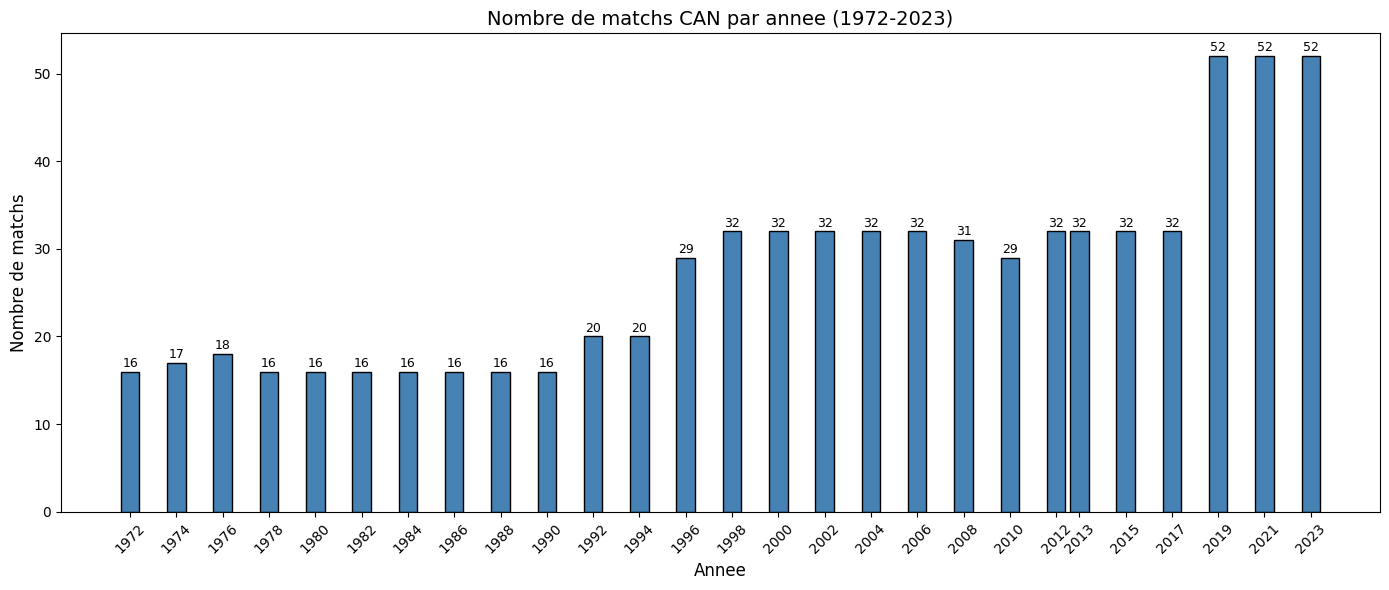

Graphique sauvegarde dans: images/matches_per_year_after_correction.png
Total: 736 matchs sur 27 editions


In [11]:
import matplotlib.pyplot as plt

# Creer le dossier images s'il n'existe pas
os.makedirs('images', exist_ok=True)

# Calculer le nombre de matchs par annee
matches_per_year = df.groupby('year').size()

# Creer le graphique
plt.figure(figsize=(14, 6))
plt.bar(matches_per_year.index, matches_per_year.values, color='steelblue', edgecolor='black')
plt.xlabel('Annee', fontsize=12)
plt.ylabel('Nombre de matchs', fontsize=12)
plt.title('Nombre de matchs CAN par annee (1972-2023)', fontsize=14)
plt.xticks(matches_per_year.index, rotation=45)

# Ajouter les valeurs sur chaque barre
for year, count in zip(matches_per_year.index, matches_per_year.values):
    plt.text(year, count + 0.2, str(count), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('images/matches_per_year_after_correction.png', dpi=150)
plt.show()

print(f"Graphique sauvegarde dans: images/matches_per_year_after_correction.png")
print(f"Total: {matches_per_year.sum()} matchs sur {len(matches_per_year)} editions")

## Scrape 2025 Fixtures

In [14]:
service = Service("chromedriver.exe")
driver = webdriver.Chrome(service=service)

url = f"https://fr.wikipedia.org/wiki/Coupe_d%27Afrique_des_nations_de_football_2025"
matches_2025 = []

try:
    driver.get(url)
    print("Scraping CAN 2025 (Fixtures)...")
except:
    print("ERREUR: Impossible de charger la page CAN 2025")

tables = driver.find_elements(By.TAG_NAME, "table")

for table in tables:
        try:
            rows = table.find_elements(By.TAG_NAME, "tr")
            if not rows:
                print("Table ignoree (2025): Aucune ligne trouvee")
                continue

            cells = rows[0].find_elements(By.TAG_NAME, "td")
            if len(cells) < 5:
                print(f"Table ignoree (2025): Structure invalide ({len(cells)} colonnes)")
                continue

            match_number = cells[0].text.strip()
            team_A = cells[1].text.strip()
            team_B = cells[3].text.strip()
            stadium = cells[4].text.strip()

            matches_2025.append([
                2025,
                match_number,
                team_A,
                team_B,
                '',
                '',
                stadium
            ])

        except Exception as e:
            print(f"ERREUR lors du traitement d'une table (2025): {str(e)[:50]}")
            continue

driver.quit()
print(f"Total matchs 2025 extraits: {len(matches_2025)}")

Scraping CAN 2025 (Fixtures)...
Table ignoree (2025): Structure invalide (1 colonnes)
Table ignoree (2025): Structure invalide (1 colonnes)
Table ignoree (2025): Structure invalide (0 colonnes)
Table ignoree (2025): Structure invalide (1 colonnes)
Table ignoree (2025): Structure invalide (0 colonnes)
Table ignoree (2025): Structure invalide (0 colonnes)
Table ignoree (2025): Structure invalide (0 colonnes)
Table ignoree (2025): Structure invalide (0 colonnes)
Table ignoree (2025): Structure invalide (0 colonnes)
Table ignoree (2025): Structure invalide (0 colonnes)
Table ignoree (2025): Structure invalide (0 colonnes)
Table ignoree (2025): Structure invalide (0 colonnes)
Table ignoree (2025): Structure invalide (0 colonnes)
Table ignoree (2025): Structure invalide (0 colonnes)
Table ignoree (2025): Structure invalide (0 colonnes)
Table ignoree (2025): Structure invalide (0 colonnes)
Table ignoree (2025): Structure invalide (0 colonnes)
Table ignoree (2025): Structure invalide (0 colonn

In [19]:
df_matches_2025= pd.read_csv("data\can_matches_2025.csv")
print(f"Shape: {df_matches_2025.shape}")
df_matches_2025.head(54)

Shape: (52, 6)


<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\User\AppData\Local\Temp\ipykernel_7792\3973950447.py:1: SyntaxWarning: invalid escape sequence '\c'
  df_matches_2025= pd.read_csv("data\can_matches_2025.csv")


,HomeTeam,AwayTeam,Year,HomeGoals,AwayGoals,match_number
0,Maroc,Comores,2025,NaN,NaN,Match 1
1,Mali,Zambie,2025,NaN,NaN,Match 2
2,Maroc,Mali,2025,NaN,NaN,Match 13
3,Zambie,Comores,2025,NaN,NaN,Match 14
4,Zambie,Maroc,2025,NaN,NaN,Match 25
5,Comores,Mali,2025,NaN,NaN,Match 26
6,Égypte,Zimbabwe,2025,NaN,NaN,Match 3
7,Afrique du Sud,Angola,2025,NaN,NaN,Match 4
8,Égypte,Afrique du Sud,2025,NaN,NaN,Match 15
9,Zimbabwe,Angola,2025,NaN,NaN,Match 16


## Scrape Group Tables

In [23]:
from string import ascii_uppercase as alphabet

service = Service("chromedriver.exe")
driver = webdriver.Chrome(service=service)

try:
    driver.get(url)
    print("Scraping des tableaux de groupes CAN 2025...")
except:
    print("ERREUR: Impossible de charger la page pour les groupes")

tables = driver.find_elements(By.CSS_SELECTOR, "table.wikitable.centre")
df_group_tables = {}

for table in tables:
    try:
        caption = table.find_element(By.TAG_NAME, "caption").text
        if "Classement" not in caption:
            continue
            
        tbody = table.find_element(By.TAG_NAME, "tbody")
        rows = tbody.find_elements(By.TAG_NAME, "tr")
        data = []

        for row in rows:
            cells = row.find_elements(By.TAG_NAME, "td")
            if len(cells) != 10:
                continue
            row_data = [cell.text.strip() for cell in cells]
            data.append(row_data)

        columns = [
            "Rang", "Équipe", "Pts", "J",
            "G", "N", "P",
            "Bp", "Bc", "Diff"
        ]

        df = pd.DataFrame(data, columns=columns)
        df_group_tables[f"Group_{alphabet[len(df_group_tables)]}"] = df
        
    except:
        continue

driver.quit()

print(f"Extracted {len(df_group_tables)} group tables.")
print("Sample - Group A:")
print(df_group_tables.get("Group_A", "Aucun groupe trouve"))

Scraping des tableaux de groupes CAN 2025...
Extracted 6 group tables.
Sample - Group A:
  Rang   Équipe Pts  J  G  N  P Bp Bc Diff
0    1  Maroc H   7  3  2  1  0  6  1   +5
1    2     Mali   3  3  0  3  0  2  2    0
2    3  Comores   2  3  0  2  1  0  2   -2
3    4   Zambie   2  3  0  2  1  1  4   -3


In [24]:
# Ramener les résultats à zéro (pour simulation)
for group_name, group_df in df_group_tables.items():
    group_df["Pts"] = 0
    group_df["J"] = 0
    group_df["G"] = 0
    group_df["N"] = 0
    group_df["P"] = 0
    group_df["Bp"] = 0
    group_df["Bc"] = 0
    group_df["Diff"] = 0

print("Tous les resultats des groupes ont ete remis a zero.")
print("Exemple - Group A:")
print(df_group_tables["Group_A"])

Tous les resultats des groupes ont ete remis a zero.
Exemple - Group A:
  Rang   Équipe  Pts  J  G  N  P  Bp  Bc  Diff
0    1  Maroc H    0  0  0  0  0   0   0     0
1    2     Mali    0  0  0  0  0   0   0     0
2    3  Comores    0  0  0  0  0   0   0     0
3    4   Zambie    0  0  0  0  0   0   0     0


## Save Raw Data to data/ folder

In [28]:
# Save historical matches
df.to_csv("data/can_matches.csv", index=False)
print("✓ Saved: data/can_matches.csv")

# Save group tables
with open('data/can_group_tables.pkl', 'wb') as output:
    pickle.dump(df_group_tables, output)
print("✓ Saved: data/can_group_tables.pkl")

✓ Saved: data/can_matches.csv
✓ Saved: data/can_group_tables.pkl
